# Procesamiento de las imagenes de los landmarks

Robots Autónomos. Mapas Topológicos visuales

Autores:
    Alejandro Benítez López, Elena Benito Frey, Mario González Carbayo, Isidro López Dominguez, Blanca Martínez Donoso y Ángel Pavón Pérez

In [8]:
import cv2
import numpy as np
import glob
import os
import matplotlib.pyplot as plt 
import pickle
import pathlib
import random
from PIL import Image, ImageStat

directory = os.getcwd() + "/"

### Extraer imágenes dado un vídeo

Se carga un vídeo y se sacan capturas de él:

In [14]:
# el nombre del video que se quiere cargar
video_name = "landmarks_3.mp4"
cap = cv2.VideoCapture(directory + 'landmarks_videos/' + video_name)

# numero de imagenes por cada landmark
image_count = [0] * 9

while(True):
    
    ret, frame = cap.read()
    
    if ret:
        
        cv2.imshow(video_name,frame)
        
        k = cv2.waitKey(10) 
        
        # si se pulsa 'q' se cierra el video
        if k & 0xFF == ord('q'):
            break
        
        if k >= 48 and k <= 57: 
            # dependiendo de que tecla numerica se usa (0-8) se asigna ese numero de landmark a la imagen.
            # la imagen se guarda en la carpeta que le corresponde.
            cv2.imwrite(directory + "landmarks_img/" + str(int(k) - 48) + "/landmark_" + str(int(k) - 48) + "_frame_" + str(image_count[int(k) - 48]) +".jpg", frame) # cambiar aqui
            image_count[int(k) - 48] += 1
        
    else:
        break

    
cap.release()
cv2.destroyAllWindows()

### Cálculo del histograma de una imagen

Se generan todos los histogramas normalizados y se guardan en un diccionario:

In [2]:
# para hacer los calculos mas eficientes se reduce las imagenes a esta resolucion
output_dimension = (848, 480)

# diccionario donde se guardaran todos los histogramas
hist_dict = {}

for i in range(9):
    # cargamos las imagenes de landmark
    filenames = [img for img in glob.glob(directory + "landmarks_img/"+ str(i) + "/*.jpg")]
    filenames.sort()

    images    = [cv2.imread(img)       for img in filenames]
    img_names = [os.path.basename(img) for img in filenames]
    
    # para todas las imagenes cargadas de este landmark:
    for j, img in enumerate(images):
        # se redimensiona la imagen
        res_img = cv2.resize(img, output_dimension, interpolation=cv2.INTER_CUBIC)
        # se sacan los canales de color de la imagen
        bgr_planes = cv2.split(res_img)
        
        # se calcula el histograma de cada canal de color de la imagen
        b_hist = np.squeeze(cv2.calcHist(bgr_planes,[0],None,[256],[0,256]))
        g_hist = np.squeeze(cv2.calcHist(bgr_planes,[1],None,[256],[0,256]))
        r_hist = np.squeeze(cv2.calcHist(bgr_planes,[2],None,[256],[0,256]))
        
        # se juntan de nuevo los tres canales
        hist = np.stack((b_hist, g_hist, r_hist), axis=0)
        
        # se calcula el historgama normalizado
        hist_norm = hist / (output_dimension[0] * output_dimension[1])
        
        # se añade al diccionario. La clave es el nombre de la imagen y el valor es su histograma normalizado 
        hist_dict[img_names[j]] = hist_norm 
        
        
    print(f"Landmark {i}. Number Of Histograms: {str(len(hist_dict))}")


Landmark 0. Number Of Histograms: 73
Landmark 1. Number Of Histograms: 135
Landmark 2. Number Of Histograms: 228
Landmark 3. Number Of Histograms: 310
Landmark 4. Number Of Histograms: 371
Landmark 5. Number Of Histograms: 458
Landmark 6. Number Of Histograms: 536
Landmark 7. Number Of Histograms: 599
Landmark 8. Number Of Histograms: 664


Dado un nombre de imagen se genera una gráfica con su histograma:

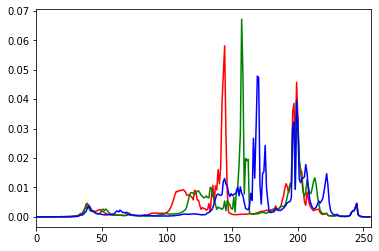

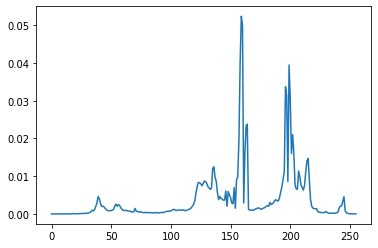

In [4]:

image = cv2.imread(directory + "landmarks_img/1/landmark_1_frame_10.jpg")

# histograma a color:
for i, col in enumerate(['r', 'g', 'b']):
    hist = cv2.calcHist([image], [i], None, [256], [0, 256])
    hist_norm = hist / (output_dimension[0] * output_dimension[1])
    plt.plot(hist_norm, color = col)
    plt.xlim([0, 256])
    
plt.show()


# histograma de escala de grises
image = cv2.imread(directory + "landmarks_img/1/landmark_1_frame_10.jpg",cv2.IMREAD_GRAYSCALE)

hist = cv2.calcHist([image],[0],None,[256],[0,256])
hist_norm = hist / (output_dimension[0] * output_dimension[1])
plt.figure() 
plt.plot(hist_norm)
    

### Comprobar imágenes repetidas

In [6]:
for i in range(9):
    image_folder = os.path.join(os.getcwd(), 'landmarks_img/' + str(i))
    image_files = [_ for _ in os.listdir(image_folder) if _.endswith('jpg')]

    duplicate_files = []

    for file_org in image_files:
        if not file_org in duplicate_files:
            image_org = Image.open(os.path.join(image_folder, file_org))
            pix_mean1 = ImageStat.Stat(image_org).mean

            for file_check in image_files:
                if file_check != file_org:
                    image_check = Image.open(os.path.join(image_folder, file_check))
                    pix_mean2 = ImageStat.Stat(image_check).mean

                    if pix_mean1 == pix_mean2:
                        duplicate_files.append((file_org))
                        duplicate_files.append((file_check))

    print (f"Imagenes repetidas landmark {i}: " + str(list(dict.fromkeys(duplicate_files))))

Imagenes repetidas landmark 0: []
Imagenes repetidas landmark 1: []
Imagenes repetidas landmark 2: []
Imagenes repetidas landmark 3: []
Imagenes repetidas landmark 4: []
Imagenes repetidas landmark 5: []
Imagenes repetidas landmark 6: []
Imagenes repetidas landmark 7: []
Imagenes repetidas landmark 8: []


### Renombrar dataset

In [ ]:
for i in range(9):
    filenames = [img for img in glob.glob(directory + "landmarks_img/" + str(i) +"/*.jpg")]

    f=0    
    for img in pathlib.Path(directory + "landmarks_img/" + str(i)).iterdir():
         if img.is_file():

            old_name = img.stem

            old_extension = img.suffix

            new_name = 'landmark_' + str(i) + '_frame_' + str(f) + old_extension

            img.rename(pathlib.Path(directory + 'landmarks_img/'+ str(i), new_name))
            f+=1

### Redimensionar dataset

In [ ]:
output_dimension = (848, 480)

for i in range(9):
    for filename in glob.glob(directory + 'landmarks_img/' + str(i) + '/*.jpg'):
        im = Image.open(filename)
        imResize = im.resize(output_dimension, Image.ANTIALIAS)
        imResize.save(filename, quality=100)
        

### Generar la media de todas las imagenes e histogramas de cada landmark

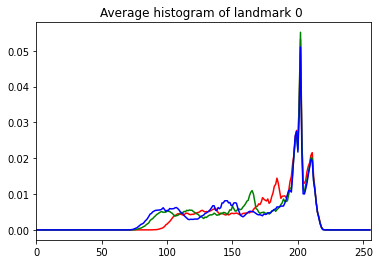

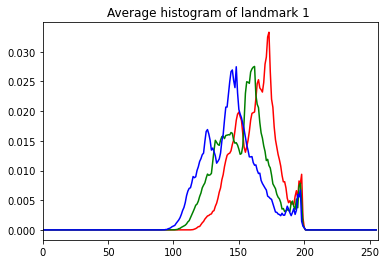

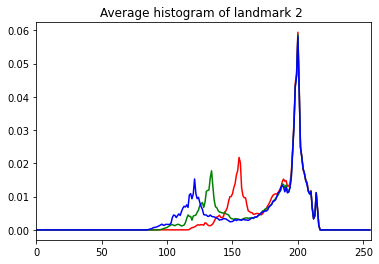

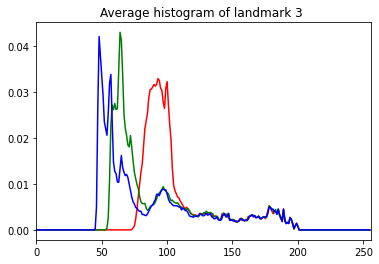

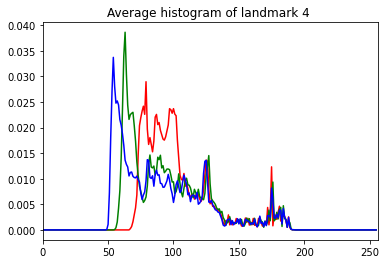

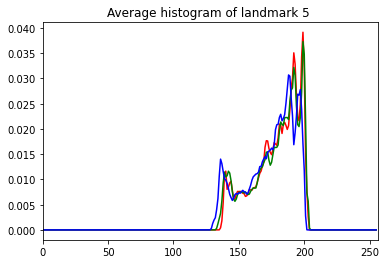

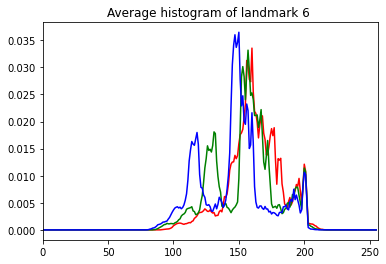

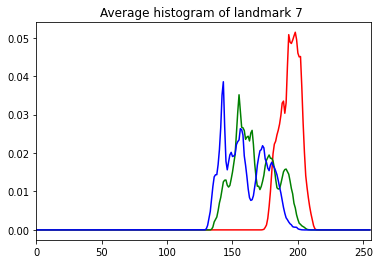

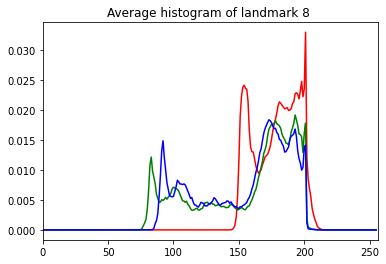

In [15]:
# color
for i in range(9):
    filenames = [img for img in glob.glob(directory + "landmarks_img/" + str(i) +"/*.jpg")]

    w,h = output_dimension
    N = len(filenames)

    # Create a numpy array of floats to store the average (assume RGB images)
    arr = np.zeros((h,w,3),np.float)

    # Build up average pixel intensities, casting each image as an array of floats
    for im in filenames:
        imarr=np.array(Image.open(im),dtype=np.float)
        arr=arr+imarr/N

    # Round values in array and cast as 8-bit integer
    arr = np.array(np.round(arr),dtype=np.uint8)
    
    out=Image.fromarray(arr,mode="RGB")
    out.save(directory + 'examples/Average_landmark_' + str(i) +'.png')
    
    for j, col in enumerate(['r', 'g', 'b']):
        hist = cv2.calcHist([arr], [j], None, [256], [0, 256])
        hist_norm = hist / (output_dimension[0] * output_dimension[1])
        plt.plot(hist_norm, color = col)
        plt.title(f"Average histogram of landmark {i} ")
        plt.xlim([0, 256])
        plt.savefig(directory + 'examples/Average_histogram_landmark_' + str(i) +'.png')
    
    plt.show()
    

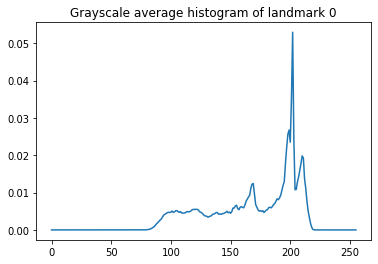

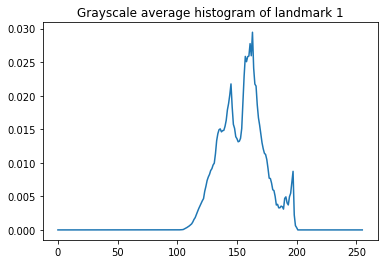

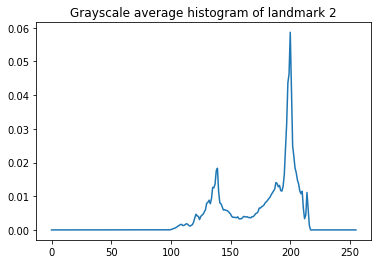

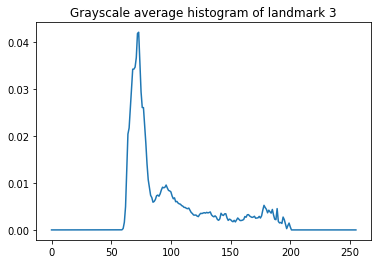

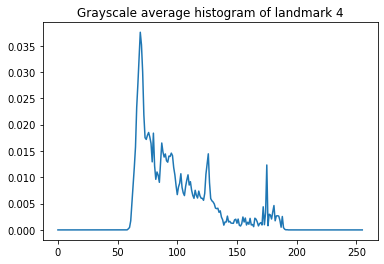

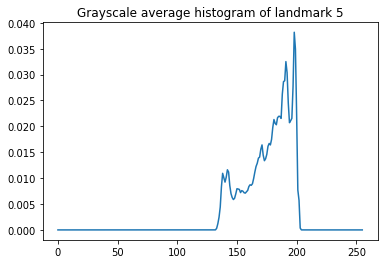

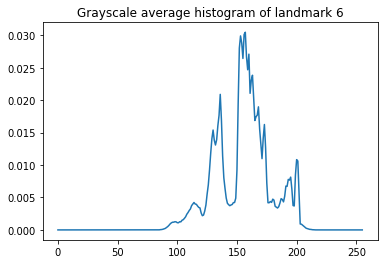

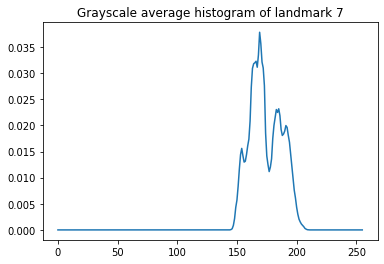

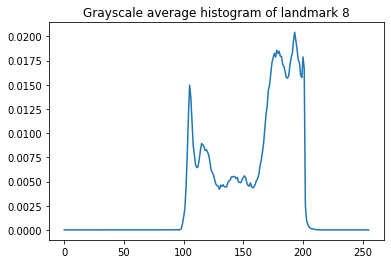

In [16]:
# Escala de grises
filenames = [img for img in glob.glob(directory + "examples/Average_landmark_*.png")]
for i in range(len(filenames)):
    g_img = cv2.imread(filenames[i], cv2.IMREAD_GRAYSCALE)
    
    hist = cv2.calcHist([g_img],[0],None,[256],[0,256])
    hist_norm = hist / (output_dimension[0] * output_dimension[1])

    plt.figure()
    plt.title(f"Grayscale average histogram of landmark {i}")    
    plt.plot(hist_norm)
    plt.savefig(directory + 'examples/gray_average_histogram_landmark_' + str(i) +'.png')